# Lane Detection Using Semantic Segmentation ENet Model

The purpose of the code is to create an effective lane marking algorithm that can be used by an autonomous vehicle so that it can understand the content in the images and thus make informed decisions.


### Import of the required libraries

In [81]:
import json
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
#import bezier
import numpy as np
import numpy
import cv2

import glob
from random import shuffle
import os
import shutil
from shutil import copy2

import itertools
import glob

from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, ZeroPadding2D
from keras.layers.core import SpatialDropout2D, Permute, Activation, Reshape
from keras.layers.merge import add, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.engine.topology import Input
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


from keras.optimizers import Adam, RMSprop 
from keras.metrics import binary_crossentropy
from keras.metrics import categorical_crossentropy

from keras import backend as K

import tensorflow as tf
import numpy as np

import time

## Data Split

The Data is split into training, testing and validation in a ratio of 0.7:0.15:0.15

In [51]:
import sys
def split_data(image_path, masks_path):
    images = glob.glob( image_path + "*.jpg"  )
    masks = glob.glob( masks_path + "*.jpg"  )
    images.sort()
    masks.sort()
    
    assert len( images ) == len(masks)
#     print(images)
#     print(masks)
    for im , seg in zip(images,masks):
#         print('image:')
#         print(im.split('\\')[-1].split(".")[0])
#         print('mask')
#         print(seg.split('\\')[-1].split(".")[0])
        assert(  im.split('\\')[-1].split(".")[0] ==  seg.split('\\')[-1].split(".")[0] )
    
    shuffle(images)
    
    directory = ['./data/train/image', './data/train/mask', 
                 './data/valid/image', './data/valid/mask',
                './data/test/image', './data/test/mask']
    
    
    for i in directory:
        if not os.path.exists(i):
            os.makedirs(i)
    
    length = len(images)
    
    train = int(0.7 * length)
    valid = int(0.15 * length)
    test  = length - train - valid
    
#     print(length)
#     print(train)
#     print(valid)
#     print(test)  
    
    for i, j in enumerate(images):
        j = j.split('\\')[-1].split(".")[0]
        #print(i)
        #print(j)
        #sys.exit()
        if i < (0.7*length):
#             print('train')
#             print('i < (0.7*length)')
            shutil.copy2(image_path +j+".jpg", directory[0])
            shutil.copy2(masks_path +j+".jpg", directory[1])
                       
        elif i < (0.85*length):
#             print('valid')
#             print('i < (0.85*length)')
            shutil.copy2(image_path +j+".jpg", directory[2])
            shutil.copy2(masks_path +j+".jpg", directory[3])

        else:
#             print('test')
#             print('i > (0.85*length)')
            shutil.copy2(image_path +j+".jpg", directory[4])
            shutil.copy2(masks_path +j+".jpg", directory[5])  

In [52]:
split_data('./data/binary_lane_bdd/Images/', './data/binary_lane_bdd/Labels/')

Reading a mask and an image and superimposing the same

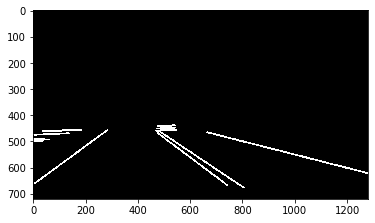

In [55]:
mask = cv2.imread('./data/train/mask/0b9e72e1-2855d45f.jpg') 
plt.imshow(mask)

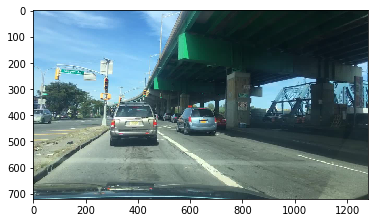

In [56]:
img = cv2.imread('./data/train/image/0b9e72e1-2855d45f.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


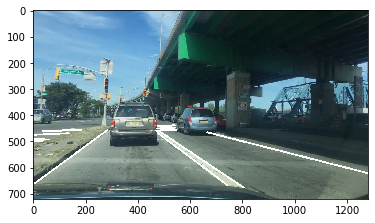

In [57]:
output = cv2.addWeighted(img, 0.9, mask, 1, 1)
# Opens a new window and displays the output frame
plt.imshow(output)

## Creating Generator

In order to prevent loading all the images onto the disk at once a generator is created. The function would read a batch of images and their corresponding masks from the disk. Applies the following transformations:

-  Converting the mask into a binary image having channels equal to the number of classes
-  Resizing the image and teh maks to 720 x 1204
-  Applies canny operation to the image based on an input parameter

#### Creating function for Canny operation

In [59]:
def do_canny(frame):
    blur = cv2.GaussianBlur(frame, (5, 5), 0)
    blur = np.uint8(blur)
    canny = cv2.Canny(blur, 50, 100)
    return canny


#### Creating the generator body

In [60]:

def generator(image_path, mask_path, batch_size, input_height, input_width, labels, input_type):
    
    assert image_path[-1] == '/'
    assert mask_path[-1] == '/'
    
    images = glob.glob( image_path + "*.jpg"  ) 
    images.sort()
    segmentations  = glob.glob( mask_path + "*.jpg"  )
    segmentations.sort()
       
    assert len( images ) == len(segmentations)

    for im , seg in zip(images,segmentations):
        assert(  im.split('\\')[-1].split(".")[0] ==  seg.split('\\')[-1].split(".")[0] )
        
    zipped = itertools.cycle( zip(images,segmentations) )
    
    while True:
        X = []
        Y = []
        for _ in range(batch_size) :
            im , seg = next(zipped)
            #reading image
            img = cv2.imread(im)[:,:,::-1]
            img = cv2.resize(img, ( input_width , input_height ),interpolation=cv2.INTER_NEAREST)
            
            #Applying canny operation if asked for
            if(input_type =='canny'):
                img = do_canny(img)
                img[0:250, :]=0
                img = np.expand_dims(img, axis=2)
            
            #Scaling the input image
            img = img.astype(np.float32)
            img = img/255.0
            
            X.append(img)
            
            #reading the mask
            img1 = cv2.imread(seg, 0)
            img1 = cv2.resize(img1, ( input_width , input_height ),interpolation=cv2.INTER_NEAREST)
            seg_labels = np.zeros((input_height , input_width  , len(labels)))
            
            #Transforming into binary
            for c,l in enumerate(labels):
                seg_labels[: , : , c ] = ((img1 == l))*1
            
            seg_labels = seg_labels.astype(np.float32)
              
            Y.append(seg_labels)
            
        yield (np.array(X) , np.array(Y))
    

## Enet Architecture 
 
 
The Enet architecture contains of five major regions wherein the first three belong to the encoder while teh last two to the decoder. In the same spirit the functions for encoder & decoder have been defined sepertely. The same are called in the main function repeatedly to create the model.

-  In order to decrease the number of parameters a bottleneck implements a series of operations. Firstly, the input is convolved with a 1x1 kernel to reduce the number of channels followed by the main operation. Thus, reducing the number of calculations to be performed. The output is again convolved with a 1x1 convolution to produce back the original number of channels. To regularize the output, a dropout layer is added.  Finally, a skip connection from the input is added back to the output to preserve spatial information.	
	
-  In case the bottleneck is down-sampling the 1x1 convolution in the bottleneck is replaced with that of having a kernel of 2x2 and a stride of 2x2 whereas a maxpooling layer is added to the skip connection to match the size of the output from the other branch. 

-  On the other hand, if the bottleneck is up-sampling the main convolution in the bottleneck is replaced with a transpose convolution while an upsampling layer is added to the skip connection to match the size of the output from the other branch. 


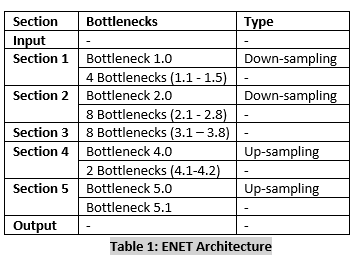

In [61]:
#encoder
def downsample_bottleneck(o, output_size , asymmetric=0, dilated=0, downsample=0):

    second_branch = o
    input_n_channels = o.get_shape().as_list()[3]
    padding = output_size - input_n_channels
    
    # reducing the channels (1x1)
    if downsample:
        stride = 2
    else:
        stride =1
    
    o = Conv2D(output_size//4, (stride, stride),strides=(stride, stride), use_bias=False)(o)
    o = BatchNormalization(momentum=0.1)(o) 
    o = PReLU(shared_axes=[1, 2])(o)

    # Perfroming convolution (COnv) 
    if asymmetric: 
        o = Conv2D(output_size//4, (1, asymmetric), padding='same', use_bias=False)(o)
        o = Conv2D(output_size//4, (asymmetric, 1), padding='same')(o)
    else:
        if dilated:
            o = Conv2D(output_size//4, (3, 3), dilation_rate=(dilated, dilated), padding='same')(o)
        else:
            o = Conv2D(output_size//4, (3, 3), padding='same')(o)
            
    o = BatchNormalization(momentum=0.1)(o) 
    o = PReLU(shared_axes=[1, 2])(o)

    # Producing back the channels (1x1) 
    o = Conv2D(output_size, (1, 1), use_bias=False)(o)
    o = BatchNormalization(momentum=0.1)(o)  
    
    # Performing regularization (Regularizer)
    o = SpatialDropout2D(0.1)(o)

    # Second branch
    
    #performing max pooling only if downsample
    if downsample:
        second_branch = MaxPooling2D()(second_branch)
    
        #performing padding -- only required if downsampling
        second_branch = Permute((1, 3, 2))(second_branch)
        second_branch = ZeroPadding2D(padding=((0, 0), (0, padding)))(second_branch)
        second_branch = Permute((1, 3, 2))(second_branch)

    o = add([o, second_branch])
    o = PReLU(shared_axes=[1, 2])(o)

    return o

In [62]:
# decoder
def upsample_bottleneck(o, output_size, upsample=0):
    
    other_branch = o
    
    #reducing the number of channel by 1x1 convolution
    o = Conv2D(output_size//4, (1, 1), use_bias=False)(o)
    o = BatchNormalization(momentum=0.1)(o)
    o = Activation('relu')(o)
    
    #Perfroming upsmapling if asked for otherwise performing normal convolution operation
    if upsample:
        o = Conv2DTranspose(output_size//4, kernel_size=(3, 3), strides=(2, 2), padding='same')(o)
    else:
        o = Conv2D(output_size//4, (3, 3), padding='same', use_bias=True)(o)
        
    o = BatchNormalization(momentum=0.1)(o)
    o = Activation('relu')(o)
    
    #Producing back the channels
    o = Conv2D(output_size, (1, 1), padding='same', use_bias=False)(o)

    #Upsampling the other branch as well if upsampling is required
    if upsample:
            other_branch = Conv2D(output_size, (1, 1), padding='same', use_bias=False)(other_branch)
            other_branch = BatchNormalization(momentum=0.1)(other_branch)
            other_branch = UpSampling2D(size=(2, 2))(other_branch)

    #Adding the two branches
    o = BatchNormalization(momentum=0.1)(o)
    o = add([o, other_branch])
    o = Activation('relu')(o)

    return o

In [63]:
#Main function create the Model body

def ENet(n_classes, input_height, input_width, channels):
    
    #defining teh Input size
    img_input = Input(shape=(input_height, input_width, channels))
    
    
    ## Section Initial
    conv = Conv2D(13, (3, 3), padding='same', strides=(2,2))(img_input)
    max_pool = MaxPooling2D()(img_input)
    merged = concatenate([conv, max_pool], axis=3)
    o = BatchNormalization(momentum=0.1)(merged)
    o = PReLU(shared_axes=[1, 2])(o)
    ### Section Initial End
    
    ##Section 2 and 3 
    o = downsample_bottleneck(o, 64, downsample=True) # 1.1
    
    for _ in range(4): #1.2-1.5
        o = downsample_bottleneck(o, 64)

    o = downsample_bottleneck(o, 128, downsample=True) #2.0
    
    for _ in range(2):
        o = downsample_bottleneck(o, 128)  # 2.1
        o = downsample_bottleneck(o, 128, dilated=2)  # 2.2
        o = downsample_bottleneck(o, 128, asymmetric=5)  #2.3
        o = downsample_bottleneck(o, 128, dilated=4)  # 2.4
        o = downsample_bottleneck(o, 128)  # 2.5
        o = downsample_bottleneck(o, 128, dilated=8)  # 2.6
        o = downsample_bottleneck(o, 128, asymmetric=5)  # 2.7
        o = downsample_bottleneck(o, 128, dilated=16)  # 2.8
     
    ## Section 2 and 3 end
    
    
    ## Section 4
    o = upsample_bottleneck(o, 64, upsample=True)  # 4.0
    o = upsample_bottleneck(o, 64)  # 4.1
    o = upsample_bottleneck(o, 64)  # 4.2
    # Section 4 ends
    
    #Section 5 
    o = upsample_bottleneck(o, 16, upsample=True)  # bottleneck 5.0
    o = upsample_bottleneck(o, 16)  # bottleneck 5.1
    #section 5 ends

    o = Conv2DTranspose(filters=n_classes, kernel_size=(2, 2), strides=(2, 2), padding='same')(o)

    o = Activation('softmax')(o)
    model = Model(img_input, o)
    
    return model

## Training the model ---- RBG Image


In order to train the models Binary cross entropy has been used as the loss along with an Adam ooptimizer. The metrics used for performance checking are IoU and accuracy

The custom function to create a Mean IoU metric has been taken from the following source:

https://github.com/davidtvs/Keras-LinkNet/blob/master/metrics/miou.py


In [64]:
class MeanIoU(object):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def mean_iou(self, y_true, y_pred):
        # Wraps np_mean_iou method and uses it as a TensorFlow op.
        # Takes numpy arrays as its arguments and returns numpy arrays as
        # its outputs.
        return tf.py_func(self.np_mean_iou, [y_true, y_pred], tf.float32)

    def np_mean_iou(self, y_true, y_pred):
        # Compute the confusion matrix to get the number of true positives,
        # false positives, and false negatives
        # Convert predictions and target from categorical to integer format
        target = np.argmax(y_true, axis=-1).ravel()
        predicted = np.argmax(y_pred, axis=-1).ravel()

        # Trick from torchnet for bincounting 2 arrays together
        # https://github.com/pytorch/tnt/blob/master/torchnet/meter/confusionmeter.py
        x = predicted + self.num_classes * target
        bincount_2d = np.bincount(x.astype(np.int32), minlength=self.num_classes**2)
        assert bincount_2d.size == self.num_classes**2
        conf = bincount_2d.reshape((self.num_classes, self.num_classes))

        # Compute the IoU and mean IoU from the confusion matrix
        true_positive = np.diag(conf)
        false_positive = np.sum(conf, 0) - true_positive
        false_negative = np.sum(conf, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error and set the value to 0
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)
        iou[np.isnan(iou)] = 0

        return np.mean(iou).astype(np.float32)

## Train RBG with Binary loss

To train the model with RBG images model is created with an input having three channels. Similarly generators are created by defining that canny operation is not required.

In [65]:
#Creating the model by calling the min function for the Model

'''Parameters:

1. No of classes
2. Height of teh image
3. Width of the Image
3. No of channels in the Input'''

model = ENet(2, 720, 1280, 3)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


**Defining the Generator and checking the output**

In [87]:
#  generator(image_path, mask_path, batch_size, input_height, input_width, labels, input_type)
#     directory = ['./data/train/image', './data/train/mask', 
#                  './data/valid/image', './data/valid/mask',
#                 './data/test/image', './data/test/mask']

train_gen = generator('./data/train/image/', './data/train/mask/', 1 , 720, 1280, [0, 255], '')

In [88]:
valid_gen = generator('./data/valid/image/', './data/valid/mask/', 1 , 720, 1280, [0,  255], '')

In [89]:
test_gen = generator('./data/test/image/', './data/test/mask/', 1 , 720, 1280, [0, 255], '')

In [104]:
(b,c) = next(train_gen)

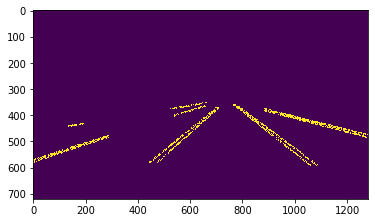

In [105]:
plt.imshow(c[0].argmax( axis=2 )*255)

(-0.5, 1279.5, 719.5, -0.5)

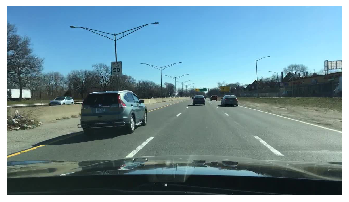

In [106]:
plt.imshow(b[0])
plt.axis('off')

**Training the model** 

In [94]:
miou_metric = MeanIoU(2)

# # Initialize our callbacks
# model_path = "./model/lane_detector_enet_v1.h5"
# checkpoint = ModelCheckpoint(model_path,
#                              monitor="val_loss",
#                              mode="min",
#                              save_best_only = True,
#                              verbose=1)

# earlystop = EarlyStopping(monitor = 'val_loss', 
#                           min_delta = 0, 
#                           patience = 5,
#                           verbose = 1,
#                           restore_best_weights = True)

model.compile(loss='binary_crossentropy', optimizer= Adam(lr=0.001) , metrics=['accuracy', miou_metric.mean_iou] )
#history1 = model.fit_generator( train_gen , 7000 , epochs=1, validation_data=valid_gen, validation_steps = 1500 )
history1 = model.fit_generator( train_gen , 500, epochs=5, validation_data=valid_gen, validation_steps = 100)
                                #callbacks = [earlystop, checkpoint])
model.save('./model/lane_detector_enet_v1.h5')
print(history1.history)

Epoch 1/5
500/500 [==============================] - 14982s 30s/step - loss: 0.0596 - acc: 0.9812 - mean_iou: 0.5005 - val_loss: 0.0839 - val_acc: 0.9808 - val_mean_iou: 0.5042
Epoch 2/5
500/500 [==============================] - 14693s 29s/step - loss: 0.0574 - acc: 0.9810 - mean_iou: 0.5219 - val_loss: 0.0734 - val_acc: 0.9802 - val_mean_iou: 0.4981
Epoch 3/5
500/500 [==============================] - 15284s 31s/step - loss: 0.0538 - acc: 0.9817 - mean_iou: 0.5349 - val_loss: 0.0696 - val_acc: 0.9810 - val_mean_iou: 0.5291
Epoch 4/5
500/500 [==============================] - 8014s 16s/step - loss: 0.0523 - acc: 0.9817 - mean_iou: 0.5479 - val_loss: 0.0703 - val_acc: 0.9812 - val_mean_iou: 0.5348
Epoch 5/5
500/500 [==============================] - 8138s 16s/step - loss: 0.0498 - acc: 0.9820 - mean_iou: 0.5524 - val_loss: 0.1066 - val_acc: 0.9805 - val_mean_iou: 0.5253
{'val_loss': [0.08387607882730663, 0.07340013827197253, 0.06956126783974469, 0.07032658860087394, 0.10660736515652389

#### Plotting the evolution of metrics for training and validation with Epoch

In [95]:
train_acc = history1.history['acc'] 
train_loss = history1.history['loss'] 
train_iou = history1.history['mean_iou']
val_acc = history1.history['val_acc'] 
val_loss = history1.history['val_loss'] 
val_iou = history1.history['val_mean_iou']

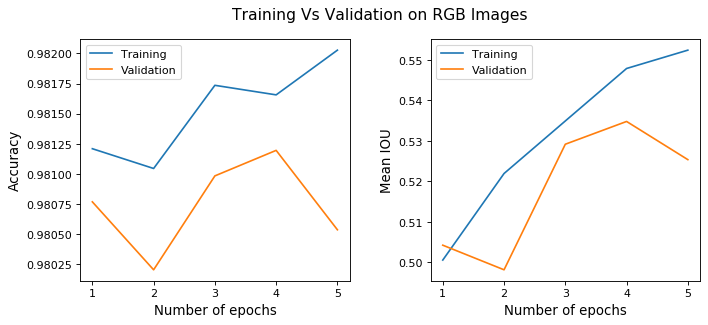

In [96]:
fig = plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
fig. suptitle('Training Vs Validation on RGB Images',  fontsize = 14)
plt.subplot(1,2,1)
plt.plot([1,2,3,4,5], train_acc,label = 'Training' )
plt.plot([1,2,3,4,5],val_acc, label = 'Validation')
plt.xlabel('Number of epochs', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.legend()

plt.subplot(1,2,2)
plt.plot([1,2,3,4,5],train_iou, label = 'Training')
plt.plot([1,2,3,4,5],val_iou, label = 'Validation')
plt.xlabel('Number of epochs', fontsize = 12)
plt.ylabel('Mean IOU', fontsize = 12)
plt.subplots_adjust(wspace =0.3)
plt.legend()

In [1]:
#reveiwing prediction for the model

Solve time: 3.7953 seconds


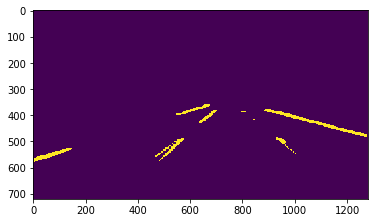

In [107]:
t0 = time.time()
plt.imshow(model.predict(b)[0].argmax(axis=2))
t1 = time.time()
print('Solve time: {:.4f} seconds'.format(round(t1 - t0, 4)))

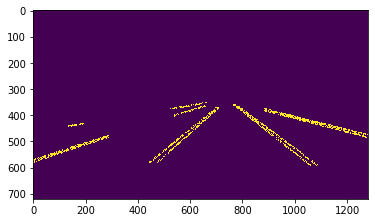

In [108]:
plt.imshow(c[0].argmax(axis=2))

In [ ]:
#restoring the model
#model.load_weights('./model/lane_detector_enet_v1.h5')

## Model Evaluation

In [109]:
# A functin which reads the input from the disk and applies the required transformations is implemented

def read_img(img_name):
    img = cv2.imread('./data/train/image/' + img_name + '.jpg')[:,:,::-1]
    img = cv2.resize(img, ( 1280 , 720 ),interpolation=cv2.INTER_NEAREST)
    img = img.astype(np.float32)
    img = img/255.0
    img = img[np.newaxis]

    return img

In [110]:
# A functin which reads the mask from the disk and applies the required transformations is implemented

def read_mask(img_name):
    img = cv2.imread('./data/train/mask/' + img_name + '.jpg')[:,:,0]
    img = cv2.resize(img, ( 1280 , 720 ),interpolation=cv2.INTER_NEAREST)
    img = img.astype(np.float32)
    img = img/255.0
    return img

In [111]:
# Afunction which calculates the accuracy, IoU and precision for the prediction is implemented
def calc_metric(num_classes, y_true, y_pred):
    
    target = y_true.ravel()
    predicted = y_pred.ravel()
    
    x = predicted + num_classes * target
    
    bincount_2d = np.bincount(x.astype(np.int32), minlength=num_classes**2)
    
    assert bincount_2d.size == num_classes**2
    
    conf = bincount_2d.reshape((num_classes, num_classes))

    true_positive = np.diag(conf)
    false_positive = np.sum(conf, 0) - true_positive
    false_negative = np.sum(conf, 1) - true_positive
    
    #print(false_positive)
    #print(false_negative)
    #print(conf)
    
    # Just in case we get a division by 0, ignore/hide the error and set the value to 0
    with np.errstate(divide='ignore', invalid='ignore'):
        iou = true_positive / (true_positive + false_positive + false_negative)
        accuracy = np.sum(true_positive)/(np.sum(true_positive)+np.sum(false_negative))
        precision = true_positive/(true_positive+false_positive)
    
    iou[np.isnan(iou)] = 0
    precision[np.isnan(precision)] = 0
    
    return (np.mean(iou).astype(np.float32), accuracy, np.mean(precision))

Plotting the original image and True label along side the prediction. The values for metrics realized have also been included. 

IoU: 0.5508 Accuracy: 0.9673 Precision: 0.6565 


Text(0.5, 1.0, 'Prediction')

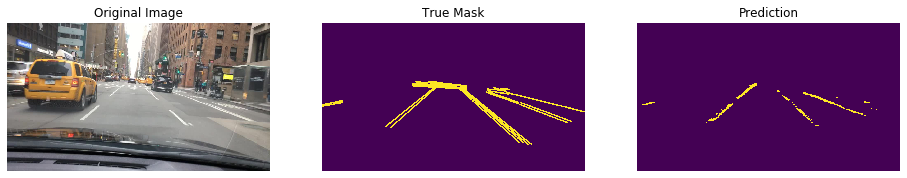

In [116]:
img = '3e1a7d8e-e69b9d84'
y_true = read_mask(img)
y_pred = model.predict(read_img(img))[0].argmax(axis = 2)
a,b,c = calc_metric(2, y_true , y_pred)
print('IoU: {:.4f} Accuracy: {:.4f} Precision: {:.4f} '.format(a,b,c))


fig = plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
plt.imshow(read_img(img)[0])
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_true)
plt.axis('off')
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(y_pred)
plt.axis('off')
plt.title('Prediction')